In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import scale

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [3]:
raw_data_scaled = pd.DataFrame(scale(raw_data.iloc[:,2:], axis = 0))
raw_data_scaled = pd.concat([raw_data.iloc[:,0:2].reset_index(drop=True), raw_data_scaled.reset_index(drop=True)], axis = 1)

In [4]:
raw_data_scaled.tail()

,time,molecule,0,1,2,3,4,5
255995,1999,124,1.123990,0.718315,0.428128,-0.374440,1.330143,-0.448040
255996,1999,125,1.570954,0.298894,0.589959,1.327699,-1.374498,-0.818153
255997,1999,126,-0.102232,1.685867,-0.113215,0.843007,2.061867,1.890516
255998,1999,127,0.826963,1.050149,0.942335,0.509793,-0.449822,-0.272515
255999,1999,128,1.499017,1.250751,1.452132,-0.266697,-0.726995,-0.019621


In [5]:
def find_neighbors(t):
    df_t = raw_data_scaled.loc[raw_data_scaled['time'] == t]
    df = df_t.iloc[:,2:5]
    
    k = 6
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(df)
    distances, indices = nbrs.kneighbors(df)
    return(k, df_t, indices)

In [6]:
def make_df(t):
    t_plus_1_df = raw_data_scaled.loc[raw_data_scaled['time']==t+1]
    t_plus_1_values = t_plus_1_df.iloc[:,2:8]
    
    li = []
    k, df, idx = find_neighbors(t)
    for i in range(0,idx.shape[0]):
        rows = []
        for j in range(0,k):
            row = df.loc[df['molecule'] == (idx[i][j]+1)]
            row_cut = np.asarray(row.iloc[:,2:8])
            rows.append(row_cut)
        
        li.append(np.array(rows).ravel())
        
    res = pd.DataFrame(li)
    df_made = pd.concat([res.reset_index(drop=True), t_plus_1_values.reset_index(drop=True)], axis = 1)
    return(df_made)

In [7]:
#make whole dataset
final_data = make_df(0)

for t in range(1,1999):
    df_part = make_df(t)
    final_data = pd.concat([final_data.reset_index(drop=True), df_part.reset_index(drop=True)], axis = 0, ignore_index=True)

In [36]:
##########################################################
################# save dataframe #########################
final_data.to_csv('./data/KNN_5.csv', index = False)

In [37]:
final_data = pd.read_csv('./data/KNN_5.csv')

In [42]:
final_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,0.1,1.1,2.1,3.1,4.1,5.1
255540,1.125765,0.717344,0.427369,-0.408145,1.361006,-0.457884,1.571953,0.298269,0.588309,1.301269,...,0.944228,0.591754,-0.397822,-0.323556,1.123990,0.718315,0.428128,-0.374440,1.330143,-0.448040
255541,1.571953,0.298269,0.588309,1.301269,-1.383293,-0.772398,1.125765,0.717344,0.427369,-0.408145,...,0.539173,0.609138,0.033438,-0.400974,1.570954,0.298894,0.589959,1.327699,-1.374498,-0.818153
255542,-0.102181,1.684884,-0.113929,0.718441,2.112893,1.939931,0.194436,1.507601,-0.600115,1.860131,...,0.067469,-2.019907,-2.652238,0.381635,-0.102232,1.685867,-0.113215,0.843007,2.061867,1.890516
255543,0.826585,1.047736,0.944228,0.591754,-0.397822,-0.323556,0.449703,1.495562,0.935043,-1.412333,...,0.427369,-0.408145,1.361006,-0.457884,0.826963,1.050149,0.942335,0.509793,-0.449822,-0.272515
255544,1.497174,1.248942,1.449231,-0.218146,-0.699282,0.014716,1.343230,1.372964,0.793929,-0.996670,...,0.935043,-1.412333,1.014507,-0.011753,1.499017,1.250751,1.452132,-0.266697,-0.726995,-0.019621


In [43]:
diff_x = final_data.iloc[:,36] - final_data.iloc[:,0]
diff_y = final_data.iloc[:,37] - final_data.iloc[:,1]
diff_z = final_data.iloc[:,38] - final_data.iloc[:,2]


diff_x_idx, = np.where(abs(diff_x) > 3)
diff_y_idx, = np.where(abs(diff_y) > 3)
diff_z_idx, = np.where(abs(diff_z) > 3)

diff_idx = set(diff_x_idx) | set(diff_y_idx) | set(diff_z_idx)

final_data = final_data.loc[final_data.index.drop(list(diff_idx))]

In [44]:
x_train, x_test, y_train, y_test = train_test_split(final_data.iloc[:,0:36], 
                                                    final_data.iloc[:,36:],
                                                    test_size = 0.3, random_state = 10)

In [48]:
#model 1
model_1 = Sequential()

model_1.add(Dense(128, input_dim=36, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(128, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(128, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(6, activation='linear', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.01)))

In [49]:
model_1.compile(loss='mean_absolute_error', optimizer= 'rmsprop', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min')
model_check_point = ModelCheckpoint('./model/KNN_5.h5', monitor = 'val_loss', verbose=2, save_best_only=True)

callback_list = [model_check_point, early_stop]

In [50]:
hist_1 = model_1.fit(x_train.values, y_train.values, epochs=150, batch_size=64, validation_data=(x_test, y_test), callbacks = callback_list)

Train on 178881 samples, validate on 76664 samples
Epoch 1/150
178881/178881 [==============================] - 14s 77us/step - loss: 0.5618 - mean_absolute_error: 0.2037 - val_loss: 0.1901 - val_mean_absolute_error: 0.1477

Epoch 00001: val_loss improved from inf to 0.19009, saving model to ./model/KNN_5.h5
Epoch 2/150
178881/178881 [==============================] - 12s 67us/step - loss: 0.2099 - mean_absolute_error: 0.1712 - val_loss: 0.1511 - val_mean_absolute_error: 0.1161

Epoch 00002: val_loss improved from 0.19009 to 0.15106, saving model to ./model/KNN_5.h5
Epoch 3/150
178881/178881 [==============================] - 12s 67us/step - loss: 0.1910 - mean_absolute_error: 0.1593 - val_loss: 0.1325 - val_mean_absolute_error: 0.1043

Epoch 00003: val_loss improved from 0.15106 to 0.13255, saving model to ./model/KNN_5.h5
Epoch 4/150
178881/178881 [==============================] - 12s 66us/step - loss: 0.1744 - mean_absolute_error: 0.1496 - val_loss: 0.1111 - val_mean_absolute_error

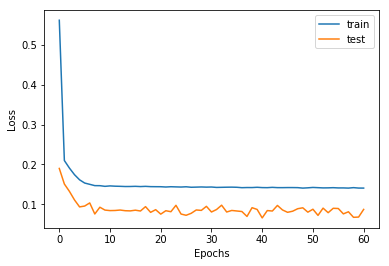

In [51]:
# plot history
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
model = load_model('./model/KNN_5.h5')

In [53]:
y_pred = pd.DataFrame(model.predict(x_test))

In [54]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred)
r2_error = r2_score(y_test.values, y_pred)

In [55]:
print("MSE:", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE: 0.006490865253275604
RMSE:  0.08056590627104994
MAE:  0.0553385943335018
R2_Score: 0.9935094693415952


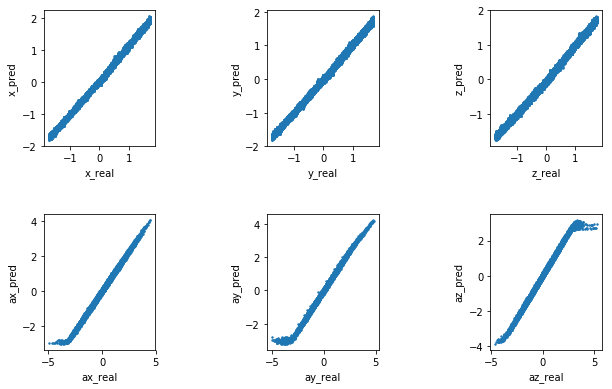

In [56]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(y_test.values[:,0], y_pred.iloc[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
#ax1.set_xlim((-2.5, 2.5))
#ax1.set_ylim((-2.5, 2.5))
ax2.scatter(y_test.values[:,1], y_pred.iloc[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
#ax2.set_xlim((-2.5, 2.5))
#ax2.set_ylim((-2.5, 2.5))
ax3.scatter(y_test.values[:,2], y_pred.iloc[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
#ax3.set_xlim((-2.5, 2.5))
#ax3.set_ylim((-2.5, 2.5))
ax4.scatter(y_test.values[:,3], y_pred.iloc[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
#ax4.set_xlim((-2.5, 2.5))
#ax4.set_ylim((-2.5, 2.5))
ax5.scatter(y_test.values[:,4], y_pred.iloc[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
#ax5.set_xlim((-2.5, 2.5))
#ax5.set_ylim((-2.5, 2.5))
ax6.scatter(y_test.values[:,5], y_pred.iloc[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')
#ax6.set_xlim((-2.5, 2.5))
#ax6.set_ylim((-2.5, 2.5))

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()

In [57]:
#cross validation

kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
data = final_data
X = final_data.iloc[:,0:36]
Y = final_data.iloc[:,36:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    
    # evaluate the model
    pred = model.predict(X.iloc[test,:])
    
    rmse = np.sqrt(mean_squared_error(Y.iloc[test,:], pred))
    mae = mean_absolute_error(Y.iloc[test,:], pred)
    r2 = r2_score(Y.iloc[test,:], pred)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

In [58]:
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))

0.08109301973549059
0.0011169986389096421


0.05533624099015174
0.0002431389491500217


0.9934213771009761
0.00016864216958572238


원래 scale로 변환

In [59]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

px_mean = np.mean(raw_data['px'])
px_std = np.std(raw_data['px'])
py_mean = np.mean(raw_data['py'])
py_std = np.std(raw_data['py'])
pz_mean = np.mean(raw_data['pz'])
pz_std = np.std(raw_data['pz'])

ax_mean = np.mean(raw_data['ax'])
ax_std = np.std(raw_data['ax'])
ay_mean = np.mean(raw_data['ay'])
ay_std = np.std(raw_data['ay'])
az_mean = np.mean(raw_data['az'])
az_std = np.std(raw_data['az'])

y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean

y_pred_df = pd.DataFrame(y_pred)

y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean

mse = mean_squared_error(y_test, y_pred_df)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred_df)
r2_error = r2_score(y_test, y_pred_df)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE:  0.06395631393893522
RMSE:  0.2528958559149106
MAE:  0.17703397240022997
R2_Score: 0.9935094697253698


In [60]:
kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
X = final_data.iloc[:,0:36]
Y = final_data.iloc[:,36:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    y_test = Y.iloc[test,:]

    y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
    y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
    y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

    y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
    y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
    y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean
    
    y_pred = model.predict(X.iloc[test,:])
    y_pred_df = pd.DataFrame(y_pred)
    
    y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
    y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
    y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

    y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
    y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
    y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_df))
    mae = mean_absolute_error(y_test, y_pred_df)
    r2 = r2_score(y_test, y_pred_df)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)
    
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))


/usr/local/anaconda/envs/env_py3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0.25419362273542906
0.002816961687370045


0.17702797561280373
0.0007137311935010981


0.993421377474524
0.00016864216371466695
